# Introduction

This sample notebook takes you through an end-to-end workflow to demonstrate the functionality of SageMaker Ground Truth. We'll leverage SageMaker core functionality along with Ground Truth to train and deploy a basic facial recognition model. In our Ground Truth labelling job, we'll present our labelers with a pair of photos and ask them to identify if the faces in photos are of the same or different person. We'll then train a siamese network model that given two face photos as inputs, will be able to tell us if these are of the same person.

### Datasets Used
Rather than splitting a single set of facial images, we'll use two completely distinct facial image datasets for training and evaluating the model
- Model Training: [AT&T Database of Faces](https://www.kaggle.com/kasikrit/att-database-of-faces)
- Model Evaluation: [Yale Face Database](https://www.kaggle.com/olgabelitskaya/yale-face-database)



In [63]:
import boto3
from sagemaker import get_execution_role
import sagemaker
import os
import random
import numpy as np
from PIL import Image
import json
import matplotlib.pyplot as plt
from sagemaker.tensorflow import TensorFlow

%matplotlib inline

In [2]:
# We'll use the default role for data access and job execution
role = get_execution_role()

# Manage interactions with the Amazon SageMaker APIs and any other AWS services needed.
sess = sagemaker.Session()

# uses a default bucket created by sagemaker
bucket = sess.default_bucket()

# Region of our account
region = sess.boto_region_name

# name of our labeling job
labeling_job_name = "face-labeling"

# path to where we'll copy all of the data
s3_root_path = os.path.join("s3://", bucket, "ground_truth_lab")

# path to data that we'll use in our Ground Truth Labeling Job
job_data_path = os.path.join(s3_root_path, "face_labeling_job_images")

# path to data that's already been labeled
labeled_data_path = os.path.join(s3_root_path, "labeled")

In [3]:
# first we upload the image data to S3
!aws s3 cp labeled {labeled_data_path} --recursive --quiet
!aws s3 cp face_labeling_job_images {job_data_path} --recursive --quiet

# Setup a Ground Truth Labeling Job
#### We'll use a private team to avoid any charges and get a better feel for the labeling user experience. First we need to setup a private team. Please follow the steps below:
1. Find the SageMaker Service in the AWS Management Console 
<img src="./notebook_images/LJ1.JPG">

2. In the SageMaker console under Ground Truth, click **Labeling workforces**
<img src="notebook_images/LT1.JPG">

3. Click **Private**
4. Click **Create private team**
<img src="notebook_images/LT3.JPG">

5. Enter **test-team** as your Team name
6. Navigate back to Console page from Step 3. Under **Workers** click **Invite new workers**

7. Put in your email address to send the invite
8. Go to your email and complete the user setup process
9. Navigate back to Console page from Step 3. This time click the team you created
10. Click **Workers** and add the worker that you created in Step 7
<img src="notebook_images/LT5.JPG">

#### Now let's go through the steps of setting up our Ground Truth Labeling Job
1. In the SageMaker console under Ground Truth, click **Labeling jobs**
<img src="notebook_images/LJ2.JPG">

2. Click **Create labeling job**
<img src="notebook_images/LJ3.JPG">

3. Run the cell below and fill in the values to setup your Ground Truth Job


In [4]:
print(f"Job name: {labeling_job_name}")
print("I want to specify...: unchecked")
print(f"S3 location for input datasets: {job_data_path}/")
print("Data type: Image")
print("Click Complete data setup")
print(f"IAM Role: {os.path.basename(role)}")
print(f"Task category: Image")
print(f"Task selection: Image Classification")

Job name: face-labeling
I want to specify...: unchecked
S3 location for input datasets: s3://sagemaker-us-east-1-152804913371/ground_truth_lab/face_labeling_job_images/
Data type: Image
Click Complete data setup
IAM Role: AmazonSageMaker-ExecutionRole-20200526T152070
Task category: Image
Task selection: Image Classification


4. Click __Next__
5. For Worker Types select __Private__
6. For Team, select the team created previously

# Model Training
Now that we have a nice labeled dataset to work with. We can begin training our model

We'll train a model emloying a Siamese network architecture where we pass in two images as inputs and the model attempts to minimize the distance based loss function to bring similar images together and push dissimilar images appart

<img src="notebook_images/siamese_network.jpg" width=600>

[Dimensionality Reduction by Learning an Invariant Mapping](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf)

In [95]:
#We'll build our model with Tensorflow. SageMaker has a managed container that can be used to run managed training jobs.
#To run a training job with Sagemaker, you just need to provide a script that trains the model and saves a the model artifact to a specified directory
#Let's take a look at the script
!pygmentize -l python src/training.py

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import Sequential, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Lambda
import numpy as np
import os
import json
import argparse


def load_and_split(path, label):
    
    """Loads and splits the image and returns a tuple of image pair and label
    
    Parameters
    ----------
    path : str
        The location of the paired image
    label : int,
        Inidcates whether the images are different(0) or same(1) 

    Returns
    -------
    tuple[tuple[Tensor[float]], Tensor[float]]
        a tuple of image pairs and the label
    """

    tf_path = tf.strings.join([f"{os.environ.get('SM_CHANNEL_TRAINING')}/", path])
    
    image = tf.io.read_file(tf_path)
    image = tf.image.decode_png(image, channels=1)
    image /= 255
    image1, image2 = image[:,:92,:], image[:,93:,:]
    
    return (image1, image2), float(labe

In [55]:
#set up the training job
model = TensorFlow(entry_point='src/training.py',
                             role=role,
                             train_instance_count=1,
                             train_instance_type='local_gpu',
                             framework_version='2.1.0',
                             py_version='py3',
                             hyperparameters = {"epochs": 10, "steps_per_epoch":32}
                      )

In [56]:
#fit model on the labeled data
model.fit(inputs=labeled_data_path)

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


Creating tmpylk930_6_algo-1-yfrxu_1 ... 
Attaching to tmpylk930_6_algo-1-yfrxu_12mdone
algo-1-yfrxu_1  | 2020-08-11 20:20:17,405 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
algo-1-yfrxu_1  | 2020-08-11 20:20:17,753 sagemaker-containers INFO     Invoking user script
algo-1-yfrxu_1  | 
algo-1-yfrxu_1  | Training Env:
algo-1-yfrxu_1  | 
algo-1-yfrxu_1  | {
algo-1-yfrxu_1  |     "additional_framework_parameters": {},
algo-1-yfrxu_1  |     "channel_input_dirs": {
algo-1-yfrxu_1  |         "training": "/opt/ml/input/data/training"
algo-1-yfrxu_1  |     },
algo-1-yfrxu_1  |     "current_host": "algo-1-yfrxu",
algo-1-yfrxu_1  |     "framework_module": "sagemaker_tensorflow_container.training:main",
algo-1-yfrxu_1  |     "hosts": [
algo-1-yfrxu_1  |         "algo-1-yfrxu"
algo-1-yfrxu_1  |     ],
algo-1-yfrxu_1  |     "hyperparameters": {
algo-1-yfrxu_1  |         "epochs": 10,
algo-1-yfrxu_1  |         "steps_per_epoch": 32,
algo-1-yfrxu_1  |       

In [57]:
predictor = model.deploy(initial_instance_count=1, instance_type='local')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


Attaching to tmp5g74qicd_algo-1-gltxi_1
algo-1-gltxi_1  | INFO:__main__:starting services
algo-1-gltxi_1  | INFO:__main__:using default model name: model
algo-1-gltxi_1  | INFO:__main__:tensorflow serving model config: 
algo-1-gltxi_1  | model_config_list: {
algo-1-gltxi_1  |   config: {
algo-1-gltxi_1  |     name: "model",
algo-1-gltxi_1  |     base_path: "/opt/ml/model",
algo-1-gltxi_1  |     model_platform: "tensorflow"
algo-1-gltxi_1  |   }
algo-1-gltxi_1  | }
algo-1-gltxi_1  | 
algo-1-gltxi_1  | 
algo-1-gltxi_1  | INFO:__main__:nginx config: 
algo-1-gltxi_1  | load_module modules/ngx_http_js_module.so;
algo-1-gltxi_1  | 
algo-1-gltxi_1  | worker_processes auto;
algo-1-gltxi_1  | daemon off;
algo-1-gltxi_1  | pid /tmp/nginx.pid;
algo-1-gltxi_1  | error_log  /dev/stderr info;
algo-1-gltxi_1  | 
algo-1-gltxi_1  | worker_rlimit_nofile 4096;
algo-1-gltxi_1  | 
algo-1-gltxi_1  | events {
algo-1-gltxi_1  |   worker_connections 2048;
algo-1-gltxi_1  | }
algo-1-gltxi_1  | 
algo-1-gltxi_1  

In [58]:
def prep_image(path):
    
    im = Image.open(path)
    im = np.array(im)
    im = im[:, (im != 255).sum(axis=0) > 50]
    im = np.array(Image.fromarray(im).resize((92,112)))
    im = im / 255
    return im[None,:,:,None]

In [59]:
def show_output(f1_sub, f1_expr, f2_sub, f2_expr, thresh=0.5):
    
    path1 = f"test_images/{f1_sub}.{f1_expr}"
    path2 = f"test_images/{f2_sub}.{f2_expr}"
    
    im1 = prep_image(path1)
    im2 = prep_image(path2)
    
    inputs = {
      'instances': [
        {"input_top":im1.tolist(),
        "input_bottom":im2.tolist()},
      ]
    }
    
    prediction = predictor.predict(inputs)['predictions'][0][0]
    
    img1 = Image.open(path1)
    img2 = Image.open(path2)
    
    fig, axes = plt.subplots(1, 2, figsize=(10,7))
    axes[0].imshow(img1, cmap='gray')
    axes[1].imshow(img2, cmap='gray')
    
    for ax in axes:
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
    
    same_dif = "same" if prediction < thresh else "different"
    
    fig.suptitle(f"Dissimilarity Score = {prediction:.3f}\n Likely {same_dif} person", y=0.85, size=20)
    plt.tight_layout()

algo-1-gltxi_1  | 2020/08/11 20:21:00 [info] 14#14: *1 client 172.18.0.1 closed keepalive connection


In [60]:
expressions = ['surprised', 'sleepy', 'glasses', 'normal', 
               'sad', 'wink', 'centerlight', 'happy', 'noglasses']

subjects = [f"subject{x:02d}" for x in range(1,16)]

algo-1-gltxi_1  | 172.18.0.1 - - [11/Aug/2020:20:37:26 +0000] "POST /invocations HTTP/1.1" 200 42 "-" "-"


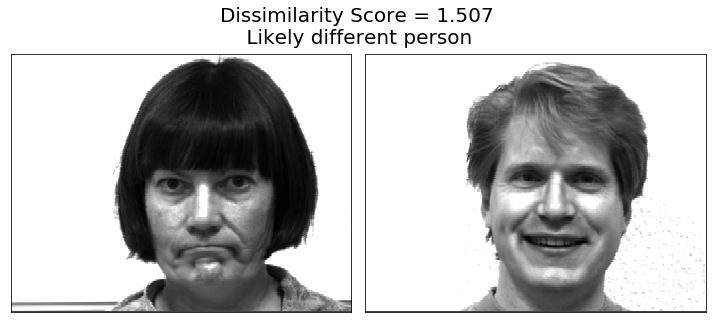

In [94]:
show_output(f1_sub = random.choice(subjects), f1_expr = random.choice(expressions),
           f2_sub = random.choice(subjects), f2_expr = random.choice(expressions))

algo-1-gltxi_1  | 172.18.0.1 - - [11/Aug/2020:20:36:27 +0000] "POST /invocations HTTP/1.1" 200 44 "-" "-"


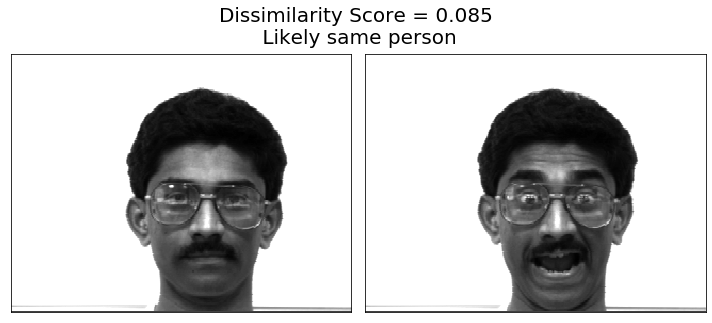

In [80]:
show_output(f1_sub = subjects[12], f1_expr = expressions[2],
           f2_sub = subjects[12], f2_expr = expressions[0])

In [54]:
#delete the endpoint 
predictor.delete_endpoint()

Gracefully stopping... (press Ctrl+C again to force)
